In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [4]:
"""
./data/clothing-dataset/ contains images which are balanced already previously
"""

'\n./data/clothing-dataset/ contains images which are balanced already previously\n'

In [9]:
from skimage.io import imread, imshow
from skimage import transform
from skimage.filters import prewitt

def preprocess_image_edge_only(image):
    resized_image = transform.resize(image, (64, 64), anti_aliasing=True)
    edges_prewitt = prewitt(resized_image)
    edges_prewitt_array = edges_prewitt.reshape(1, 64 * 64)
    return edges_prewitt_array[0]

def preprocess_image(image):
    resized_image = transform.resize(image, (64, 64), anti_aliasing=True)
    edges_prewitt = prewitt(resized_image)
    edges_prewitt_array = edges_prewitt.reshape(1, 64 * 64)
    image_array = resized_image.reshape(1, 64 * 64)
    return np.concatenate((edges_prewitt_array[0], image_array[0]))

In [45]:
# Feature: Grayscale + Edges
X_train = []
y_train = []
X_test = []
y_test = []

data_types = ["train", "test"]

image = None
count = 0
for data_type in data_types:
    folder_path = "./data/clothing-dataset/" + data_type

    for folder in os.listdir(folder_path):
        for filename in os.listdir(os.path.join(folder_path, folder)):
            # Open the image
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(folder_path, folder, filename)
                image = imread(image_path,as_gray=True)
                result = preprocess_image(image)
                if data_type == "test":
                    X_test.append(result)
                    y_test.append(folder)
                else:
                    X_train.append(result)
                    y_train.append(folder)

Number of features: 8192


(array([ 546.,  274., 1008.,  416., 1034.,  638.,  448.,  454.,  248.,
         876.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

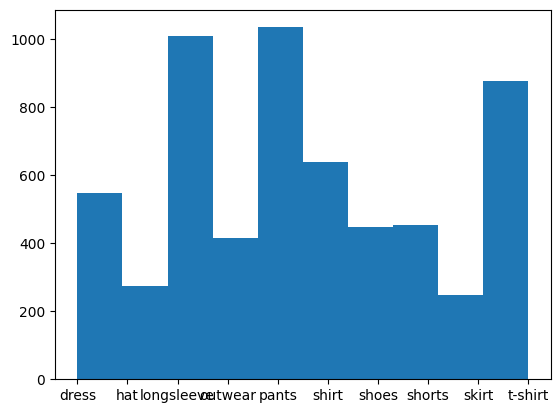

In [46]:
"""Check the distribution of labels & number of features in X_train"""
print("Number of features:", len(X_train[0]))
plt.hist(y_train)

In [47]:
"""Feature scaling"""
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.fit_transform(X_test)

Text(0.5, 1.0, 'Second image: Digit 0')

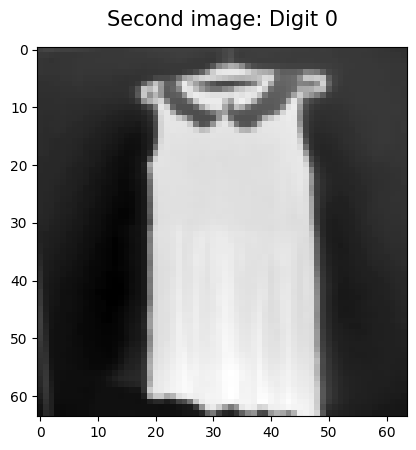

In [63]:
"""Visualise image after scaling"""

import matplotlib.pyplot as plt

second_image = X_train[0][4096:].reshape([64, 64])
plt.imshow(second_image, cmap='gray_r')
plt.title('Second image: Digit 0', fontsize=15, pad=15)

Text(0, 0.5, 'Explained variance')

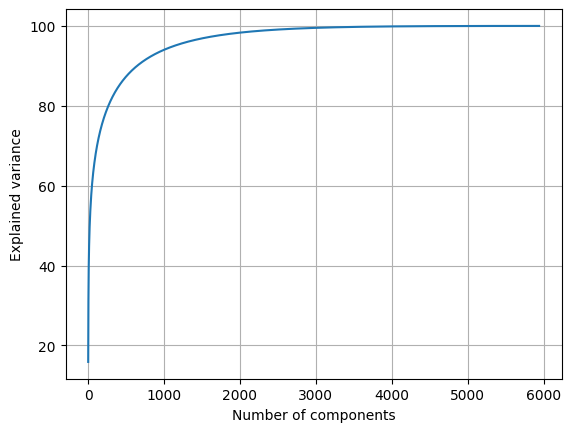

In [48]:
"""
Selecting the best number of principal components for the dataset
https://towardsdatascience.com/image-compression-using-principal-component-analysis-pca-253f26740a9f
"""
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

# First, we apply PCA with original number of dimensions (i.e. 8192) and create scree plot to see how well PCA captures variance of the data.
# However, due to limitation, we only can set the max n_components to be 5942
pca_8192 = PCA(n_components=5942)
pca_8192.fit(X_train)

plt.grid()
plt.plot(np.cumsum(pca_8192.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

"We can see below that the image doesn't capture sufficient variablility in the original data"

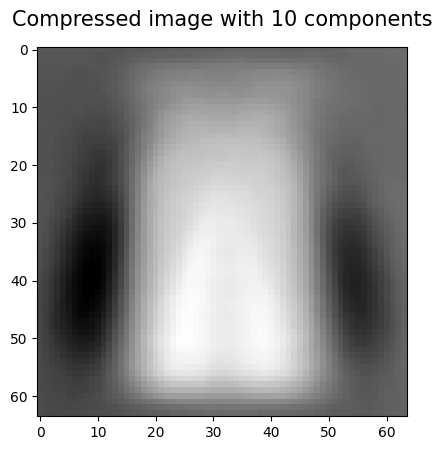

In [58]:
"""Try n_components = 10"""
pca_10 = PCA(n_components=10)
X_train_pca_10_reduced = pca_10.fit_transform(X_train)
X_train_pca_10_recovered = pca_10.inverse_transform(X_train_pca_10_reduced)

image_pca_10 = X_train_pca_10_recovered[0][4096:].reshape([64,64])
plt.imshow(image_pca_10, cmap='gray_r')
plt.title('Compressed image with 10 components', fontsize=15, pad=15)
plt.savefig("image_pca_10.png")

"""We can see below that the image doesn't capture sufficient variablility in the original data"""

% of original variability preserved:  99.50769320685855


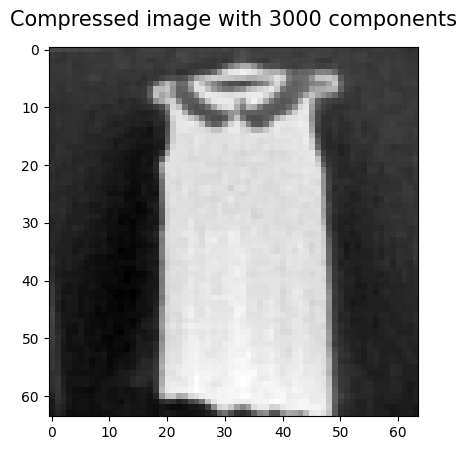

In [83]:
"""Setting n_components = 3000"""
pca_3000 = PCA(n_components=3000)
X_train_pca_3000_reduced = pca_3000.fit_transform(X_train)
X_train_pca_3000_recovered = pca_3000.inverse_transform(X_train_pca_3000_reduced)

image_pca_3000 = X_train_pca_3000_recovered[0][4096:].reshape([64,64])
plt.imshow(image_pca_3000, cmap='gray_r')
plt.title('Compressed image with 3000 components', fontsize=15, pad=15)

print("% of original variability preserved: ", np.cumsum(pca_3000.explained_variance_ratio_ * 100)[-1])

In [67]:
"""
From above, we can see that setting n=3000 preserves 99% of the original variability, and removing 5192 features.

Now, we can use data with the reduced dimensions to conduct tests for the following models:

1. KNN
2. DT
3. RandomForest
4. SVM
5. HOG
6. SIFT

We will use the evaluation metric of F1 score micro.
"""

'\nFrom above, we can see that setting n=3000 preserves 99% of the original variability, and removing 5192 features.\n\nNow, we can use data with the reduced dimensions to conduct tests for the following models:\n\n1. KNN\n2. DT\n3. RandomForest\n4. SVM\n5. HOG\n6. SIFT\n\nWe will use the evaluation metric of F1 score micro.\n'

In [82]:
""" 1. KNN """
# define the number of folds for cross validation
NUM_FOLDS = 5

# define param search space for knn and dt
knn_param_grid = {'n_neighbors': list(range(2, 100))}

# define scoring metric
f1_scorer = make_scorer(f1_score, average='micro')

# define models
knn = KNeighborsClassifier()
pca = PCA(n_components=3000)

# Fit PCA to the training data (greyscale + edges)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# KNN
knn_model = RandomizedSearchCV(knn, knn_param_grid, cv=NUM_FOLDS, scoring=f1_scorer, n_jobs=-1)
knn_model.fit(X_train_pca, y_train)

print("KNN:")
print("Best k: ", knn_model.best_params_)
print("Best F1 score for training data: ", knn_model.best_score_)

knn_final = KNeighborsClassifier(n_neighbors=int(knn_model.best_params_['n_neighbors']))
knn_final.fit(X_train_pca, y_train)
y_pred = knn_final.predict(X_test_pca)
print("Test F1 Score: ", f1_score(y_test, y_pred, average='micro'))

KNN:
Best k:  {'n_neighbors': 29}
Best F1 score for training data:  0.4730750170615604
Test F1 Score:  0.28034682080924855


In [84]:
"""2. DT"""
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

dt_param_grid = {'max_depth': list(range(2, 100))}

# define models
dt = DecisionTreeClassifier(max_features=512)
pca = PCA(n_components=3000)

# define scoring metric
f1_scorer = make_scorer(f1_score, average='micro')

# Fit PCA to the training data (greyscale + edges)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# DT
dt_model = RandomizedSearchCV(dt, dt_param_grid, cv=NUM_FOLDS, scoring=f1_scorer, n_jobs=-1)
dt_model.fit(X_train_pca, y_train)

print("DT:")
print("Best depth: ", dt_model.best_params_)
print("Best F1 score for training data: ", dt_model.best_score_)

dt_final = DecisionTreeClassifier(max_depth=int(dt_model.best_params_['max_depth']), max_features=512)
dt_final.fit(X_train_pca, y_train)
y_pred = dt_final.predict(X_test_pca)
print("Test F1 Score: ", f1_score(y_test, y_pred, average='micro'))

DT:
Best depth:  {'max_depth': 92}
Best F1 score for training data:  0.31453800692656875
Test F1 Score:  0.19219653179190754


In [89]:
"""3. RandomForest"""
from sklearn.ensemble import RandomForestClassifier


# define models
rf = RandomForestClassifier()
pca = PCA(n_components=3000)

# define scoring metric
f1_scorer = make_scorer(f1_score, average='micro')

# Fit PCA to the training data (greyscale + edges)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf_param_grid = {
    # 'n_estimators': [10, 50, 100, 200],
    'max_depth': list(range(2, 100)),
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

rf_model = RandomizedSearchCV(rf, rf_param_grid, cv=NUM_FOLDS, scoring=f1_scorer, n_jobs=-1)
rf_model.fit(X_train_pca, y_train)

print("Random Forest:")
print("Best parameters: ", rf_model.best_params_)
print("Best F1 score: ", rf_model.best_score_)

rf_final = RandomForestClassifier(**rf_model.best_params_)
rf_final.fit(X_train_pca, y_train)
y_pred_rf = rf_final.predict(X_test_pca)
print("Test F1 Score: ", f1_score(y_test, y_pred_rf, average='micro'))

Random Forest:
Best parameters:  {'max_depth': 16}
Best F1 score:  0.36502535871753705
Test F1 Score:  0.27601156069364163


In [87]:
"""4. SVM"""
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

# define models
pca = PCA(n_components=3000)

# define scoring metric
f1_scorer = make_scorer(f1_score, average='micro')

# Fit PCA to the training data (greyscale + edges)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# SVM
svc = make_pipeline(StandardScaler(), SGDClassifier(max_iter=3000))
svc.fit(X_train_pca, y_train)
y_pred = svc.predict(X_test_pca)
print("Test F1 Score: ", f1_score(y_test, y_pred, average='micro'))

# svm_model = RandomizedSearchCV(svc, param_distributions=param_dist, cv=2, scoring=f1_scorer, n_jobs=-1, n_iter=2)
# svm_model.fit(X_train, y_train)

# print("SVM")
# print("Best params: ", svm_model.best_params_)
# print("Best F1 score: ", svm_model.best_score_)

Test F1 Score:  0.3208092485549133


In [99]:
"""5. HOG"""
from skimage.feature import hog

# Feature: HOG
X_train_hog = []
y_train_hog = []
X_test_hog = []
y_test_hog = []

data_types = ["train", "test"]

image = None
count = 0
for data_type in data_types:
    folder_path = "./data/clothing-dataset-hog/" + data_type

    for folder in os.listdir(folder_path):
        for filename in os.listdir(os.path.join(folder_path, folder)):
            # Open the image
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(folder_path, folder, filename)
                image = imread(image_path)
                result = np.array(img).ravel()
                if data_type == "test":
                    X_test_hog.append(result)
                    y_test_hog.append(folder)
                else:
                    X_train_hog.append(result)
                    y_train_hog.append(folder)
                    
rf_param_grid = {
    # 'n_estimators': [10, 50, 100, 200],
    'max_depth': list(range(2, 100)),
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

# define models
pca = PCA(n_components=3000)

# define scoring metric
f1_scorer = make_scorer(f1_score, average='micro')

# Fit PCA to the training data (greyscale + edges)
X_train_pca_hog = pca.fit_transform(X_train_hog)
X_test_pca_hog = pca.transform(X_test_hog)

rf_model = RandomizedSearchCV(rf, rf_param_grid, cv=NUM_FOLDS, scoring=f1_scorer, n_jobs=-1)
rf_model.fit(X_train_pca_hog, y_train_hog)

print("Random Forest with HOG:")
print("Best parameters: ", rf_model.best_params_)
print("Best F1 score: ", rf_model.best_score_)

rf_final = RandomForestClassifier(**rf_model.best_params_)
rf_final.fit(X_train_pca_hog, y_train_hog)
y_pred_rf = rf_final.predict(X_test_pca_hog)
print("Test F1 Score: ", f1_score(y_test_hog, y_pred_rf, average='micro'))

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_pca.py:642: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Random Forest with HOG:
Best parameters:  {'max_depth': 57}
Best F1 score:  0.17401545593303375
Test F1 Score:  0.12138728323699421


In [ ]:
# Feature: SIFT
X_train_sift = []
y_train_sift = []
X_test_sift = []
y_test_sift = []

data_types = ["train", "test"]

image = None
count = 0
for data_type in data_types:
    folder_path = "./data/clothing-dataset-sift/" + data_type

    for folder in os.listdir(folder_path):
        for filename in os.listdir(os.path.join(folder_path, folder)):
            # Open the image
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(folder_path, folder, filename)
                image = imread(image_path)
                result = np.array(img).ravel()
                if data_type == "test":
                    X_test_sift.append(result)
                    y_test_sift.append(folder)
                else:
                    X_train_sift.append(result)
                    y_train_sift.append(folder)
                    
# define models
pca = PCA(n_components=3000)

# define scoring metric
f1_scorer = make_scorer(f1_score, average='micro')

# Fit PCA to the training data (sift)
X_train_pca_sift = pca.fit_transform(X_train_sift)
X_test_pca_sift = pca.transform(X_test_sift)

rf_model = RandomizedSearchCV(rf, rf_param_grid, cv=NUM_FOLDS, scoring=f1_scorer, n_jobs=-1)
rf_model.fit(X_train_pca_sift, y_train_sift)

print("Random Forest with HOG:")
print("Best parameters: ", rf_model.best_params_)
print("Best F1 score: ", rf_model.best_score_)

rf_final = RandomForestClassifier(**rf_model.best_params_)
rf_final.fit(X_train_pca_sift, y_train_sift)
y_pred_rf = rf_final.predict(X_test_pca_sift)
print("Test F1 Score: ", f1_score(y_test_sift, y_pred_rf, average='micro'))

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\decomposition\_pca.py:642: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


In [ ]:
"""Here onwards is LDA"""

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer

lle = LocallyLinearEmbedding(n_components=50, n_neighbors=100, method="modified")

# Fit PCA to the training data (greyscale + edges)
X_train_lle = lle.fit_transform(X_train)

X_test_lle = lle.transform(X_test)

# print("Transformed training data:", X_train_lle)
# print("Transformed test data:", X_test_lle)

# define models
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(max_features=512)

# define param search space for knn and dt
knn_param_grid = {'n_neighbors': list(range(2, 100))}
dt_param_grid = {'max_depth': list(range(2, 100))}

NUM_FOLDS = 5
f1_scorer = make_scorer(f1_score, average='micro')

# define models
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(max_features=512)

# PCA + KNN
knn_final = RandomizedSearchCV(knn, knn_param_grid, cv=NUM_FOLDS, scoring=f1_scorer, n_jobs=-1, n_iter=3)
knn_final.fit(X_train_lle, y_train)
y_pred = knn_final.predict(X_test_lle)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("\n The best estimator across ALL searched params:\n", knn_final.best_estimator_)
print("\n The best score across ALL searched params:\n", knn_final.best_score_)
print("\n The best parameters across ALL searched params:\n", knn_final.best_params_)

# PCA + DT
dt_final = RandomizedSearchCV(dt, dt_param_grid, cv=NUM_FOLDS, scoring=f1_scorer, n_jobs=-1, n_iter=3)
dt_final.fit(X_train_lle, y_train)
y_pred = dt_final.predict(X_test_lle)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("\n The best estimator across ALL searched params:\n", dt_final.best_estimator_)
print("\n The best score across ALL searched params:\n", dt_final.best_score_)
print("\n The best parameters across ALL searched params:\n", dt_final.best_params_)

# Outcome
# This is much slower than PCA, did not do loop
# This took around 1-2 mins

Accuracy Score:  0.3554913294797688

 The best estimator across ALL searched params:
 KNeighborsClassifier(n_neighbors=53)

 The best score across ALL searched params:
 0.5148128325588376

 The best parameters across ALL searched params:
 {'n_neighbors': 53}


In [34]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

lle = LocallyLinearEmbedding(n_components=90, n_neighbors=100, method="modified")

# Fit PCA to the training data (greyscale + edges)
X_train_lle = lle.fit_transform(X_train)

X_test_lle = lle.transform(X_test)

# print("Transformed training data:", X_train_lle)
# print("Transformed test data:", X_test_lle)

# PCA + KNN
knn_final = KNeighborsClassifier(n_neighbors=13)
knn_final.fit(X_train_lle, y_train)
y_pred = knn_final.predict(X_test_lle)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

# PCA + DT
dt_final = DecisionTreeClassifier(max_depth=65)
dt_final.fit(X_train_lle, y_train)
y_pred = dt_final.predict(X_test_lle)
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

# Outcome
# This is much slower than PCA, did not do loop
# This took around 1-2 mins

# Comments
# Maybe we need to do normalization of features first. Since this is highly dependent on neighbours.

Accuracy Score:  0.3930635838150289
Accuracy Score:  0.3092485549132948
